# Resources
https://www.wnycstudios.org/podcasts/radiolab/segments/104010-one-good-deed-deserves-another

https://fivethirtyeight.com/features/how-to-win-a-trade-war/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from DefaultBots import *     # {Player, TitForTat, Satan, Jesus, Arbitrary, MassiveRetalitoryStrike, Tester}
from DylanBots import *       # {HotStartOpportunist, HotStartWithGrudge, RetalitoryCooperator}
from EricBots import *        # {Calvin, Susan, Christy, Eric}
from DanBots import *         # {FlipACoin, SICKO_MODE}
from LindaBots import *       # {GrumpySquidward, BandwagonerSpongebob}
from JacobBots import *       # {TimeKeeper}
from ShishirBots import *     # {TatForTit, GTT}

In [3]:
def run_one_game(player1, player2, player1_prev_choices, player2_prev_choices):
    
    p1_ans = player1.evaluate_round(player2_prev_choices)
    p2_ans = player2.evaluate_round(player1_prev_choices)
    
    return p1_ans, p2_ans
    
def run_many_games(player1, player2, n_games=200, verbose=False):
    
#     n_games += 1
    
    outcome_array = np.zeros(n_games)
    p1_choices    = np.array([])
    p2_choices    = np.array([])
    
    for i in np.arange(n_games):
        p1_choice, p2_choice = run_one_game(player1, player2, p1_choices, p2_choices)
        p1_choices = np.append(p1_choices, p1_choice)
        p2_choices = np.append(p2_choices, p2_choice)
        
        p1_defect = (p1_choice == 1)
        p2_defect = (p2_choice == 1)
        
        outcome = -1
        if (p1_defect and p2_defect):
            outcome =  0
        if (p1_defect and not p2_defect):
            outcome =  1
        if (not p1_defect and p2_defect):
            outcome =  2
        if (not p1_defect and not p2_defect):
            outcome =  3
        outcome_array[i] = outcome
    
    if (verbose):
        print("Player",player1.name,"chose:",p1_choices)
        print("Player",player2.name,"chose:",p2_choices)
    return outcome_array#[1:]

def determine_winner(player1, player2, outcome_array, verbose=True):
    p1_wins = np.sum(outcome_array == 1)
    p2_wins = np.sum(outcome_array == 2)
    both_lose = np.sum(outcome_array == 0) # both defect
    both_win  = np.sum(outcome_array == 3) # both remain
    
    pts_both_defect   = 0.0
    pts_both_remain   = 1.0
    pts_opposite_win  = 2.0
    pts_opposite_lose = 0.0
    
    p1_score = p1_wins*pts_opposite_win + both_win*pts_both_remain + both_lose*pts_both_defect + p2_wins*pts_opposite_lose
    p2_score = p2_wins*pts_opposite_win + both_win*pts_both_remain + both_lose*pts_both_defect + p1_wins*pts_opposite_lose
    
#     p1_score = p1_wins + both_win
#     p2_score = p2_wins + both_win
    
    if   (p1_score > p2_score):
        if (verbose):
            print("The winner is:",player1.name,", with a score of",p1_score,"out of 400 total (",100*p1_score/400.,"%)")
            print("Loser (",player2.name,") scored:",p2_score)
            print(player1.name,"beat",player2.name,"by",p1_score-p2_score)
        return player1, p1_score, p2_score
    elif (p2_score > p1_score):
        if (verbose):
            print("The winner is:",player2.name,", with a score of",p2_score,"out of 400 total (",100*p2_score/400.,"%)")
            print("Loser (",player1.name,") scored:",p1_score)
            print(player1.name,"lost to",player2.name,"by",p1_score-p2_score)
        return player2, p1_score, p2_score
    else:
        if (verbose):
            print("Tie, both received",p1_score,"points")
        return Player(), p1_score, p2_score
       
def generational_competition(player1, player2):
    N_epochs = 100
    
    n_player1  = 1
    n_player2  = 1
    fraction_player1 = n_player1 / (n_player1+n_player2)
    
    for i in np.arange(N_epochs):
        print("After",i," epochs,",100.*fraction_player1,"% of population are ",player1.name)
        
        rando = np.random.rand()
        if (rando <= fraction_player1):
            p1 = player1
        else:
            p1 = player2
            
        rando = np.random.rand()
        if (rando <= fraction_player1):
            p2 = player1
        else:
            p2 = player2
            
        if (p1.name == p2.name):
            if   (p1.name == player1.name):
                n_player1 += 1
            elif (p1.name == player2.name):
                n_player2 += 1
        else:
            results = run_many_games(p1,p2)
            winner, p1_score, p2_score = determine_winner(p1,p2,results)
            
            if   (winner.name == player1.name):
                n_player1 += 1
            elif (winner.name == player2.name):
                n_player2 += 1

        fraction_player1 = n_player1 / (n_player1+n_player2)

    print("After",N_epochs,"epochs,",100.*fraction_player1,"% of population are ",player1.name)
    print("After",N_epochs,"epochs,",100.*(1-fraction_player1),"% of population are ",player2.name)
    if   (fraction_player1 > 0.5):
        print("Player",player1.name,"is the superior logic!")
    elif (fraction_player1 < 0.5):
        print("Player",player2.name,"is the superior logic!")
    else:
        print("WOW, you tied.")

The winner is: arbitrary-2 , with a score of 153.0 out of 400 total ( 38.25 %)
Loser ( arbitrary-1 ) scored: 135.0
arbitrary-1 lost to arbitrary-2 by -18.0


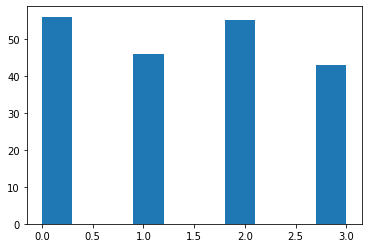

In [4]:
_p1 = Arbitrary(1)
_p2 = Arbitrary(2)
results = run_many_games(_p1,_p2)
winner, p1_score, p2_score = determine_winner(_p1,_p2,results)
n, bins, patches = plt.hist(results)

In [5]:
def RunTheGauntlet(p1, VERBOSE=False):
    N_bots = 18
    p2_array     = np.zeros(N_bots, dtype=object)
    score_array  = np.zeros(N_bots)
    oppname_arr  = np.zeros(N_bots, dtype=object)

    # Default Bots - 6
    p2_array[ 0] = TitForTat(2)
    p2_array[ 1] = Satan(2)
    p2_array[ 2] = Jesus(2)
    p2_array[ 3] = Arbitrary(2)
    p2_array[ 4] = MassiveRetalitoryStrike(2)
    p2_array[ 5] = Tester(2)
    # Dylan Bots - 3 
    p2_array[ 6] = HotStartOpportunist(2)
    p2_array[ 7] = HotStartWithGrudge(2)
    p2_array[ 8] = RetalitoryCooperator(2)
    # Eric Bots - 4
    p2_array[ 9] = Calvin(2)
    p2_array[10] = Susan(2)
    p2_array[11] = Christy(2)
    p2_array[12] = Eric(2)
    # Dan Bots - 2
    p2_array[13] = FlipACoin(2)
    p2_array[14] = SICKO_MODE(2)
    # Linda Bots - 2
    p2_array[15] = GrumpySquidward(2)
    p2_array[16] = BandwagonerSpongebob(2)
    # Jacob Bots - 1
    p2_array[17] = TimeKeeper(2)

    for i in np.arange(N_bots):
        results = run_many_games(p1,p2_array[i])
        winner, p1_score, p2_score = determine_winner(p1,p2_array[i],results,verbose=False)
        score_array[i] = p1_score
        oppname_arr[i] = p2_array[i].name
        if VERBOSE:
            if   (winner.name == p1.name):
                print(p1.name, "wins vs" , p2_array[i].name, "scoring", p1_score, "points (", p2_score, ")" )
            elif (winner.name == p2_array[i].name):
                print(p1.name, "loses vs", p2_array[i].name, "scoring", p1_score, "points (", p2_score, ")" )
            else:
                print(p1.name, "ties wth", p2_array[i].name, "scoring", p1_score, "points (", p2_score, ")" )
    return p1.name, oppname_arr, score_array

In [6]:
import pandas as pd

_p1 = Eric()
name, opp_names, scores = RunTheGauntlet(_p1)

scores = np.append(scores, np.sum(scores))
opp_names = np.append(opp_names, "TOTAL")

dframe = np.array([scores])
pd.DataFrame(dframe, columns=opp_names, index=[name])

,tit-for-tat-2,satan-2,jesus-2,arbitrary-2,massive retaliatory strike-2,tester-2,hot-start-opportunist-2,hot-start-with-a-grudge-2,retalitory-cooperator-2,calvin-2,susan-2,christy-2,eric-2,flip-a-coin-2,sicko-mode-2,grumpy-squidward-2,bandwagoner-spongebob-2,time-keeper-2,TOTAL
eric,200.0,0.0,201.0,122.0,200.0,119.0,0.0,0.0,8.0,134.0,201.0,200.0,200.0,134.0,200.0,0.0,396.0,2.0,2317.0
